<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/minimization%2Broot_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

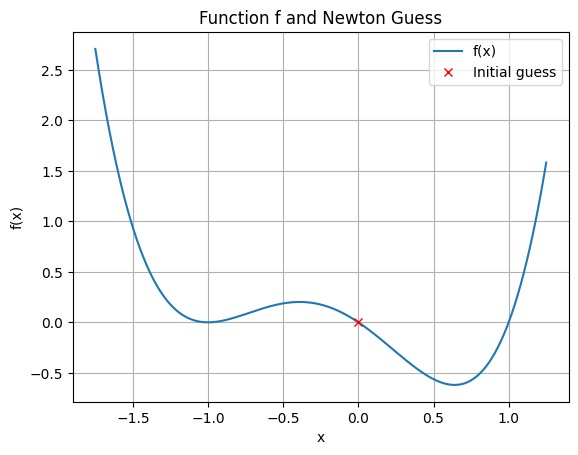

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# ------------------------
# Define f, ∇f, ∇²f
# ------------------------
def f(x):
    return x**4 + x**3 - x**2 - x

def grad_f(x):
    return 4.0 * x**3 + 3.0 * x**2 - 2.0 * x - 1.0

def hess_f(x):
    return 12.0 * x**2 + 6.0 * x - 2.0


# ------------------------
# Newton Step Function
# ------------------------
def newton_step(x0):
    return x0 - grad_f(x0) / hess_f(x0)


# ------------------------
# Plotting
# ------------------------
x = np.linspace(-1.75, 1.25, 1000)
xguess = 0.0

plt.plot(x, f(x), label='f(x)')
plt.plot(xguess, f(xguess), 'rx', label='Initial guess')
plt.title('Function f and Newton Guess')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()


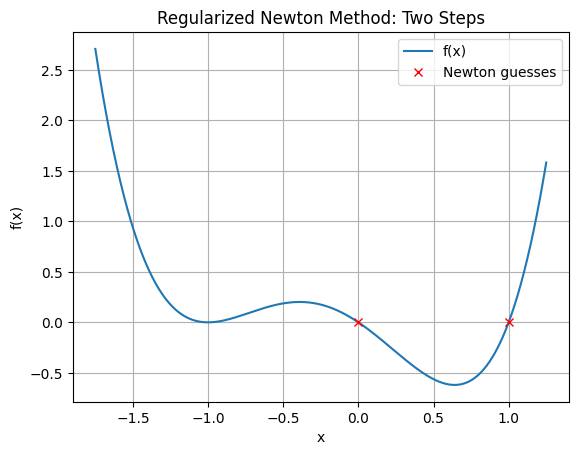

In [4]:
# Regularized Newton Step
def regularized_newton_step(x0):
    beta = 1.0
    H = hess_f(x0)

    # If Hessian is not positive definite (i.e., <= 0 for scalar), regularize
    while H <= 0:
        H += beta

    return x0 - grad_f(x0) / H

xnew = regularized_newton_step(xguess[-1])

# Append new guess to the list
xguess.append(xnew)

# Plot the function and all guesses so far
plt.plot(x, f(x), label='f(x)')
plt.plot(xguess, [f(xi) for xi in xguess], "rx", label="Newton guesses")
plt.title("Regularized Newton Method: Two Steps")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

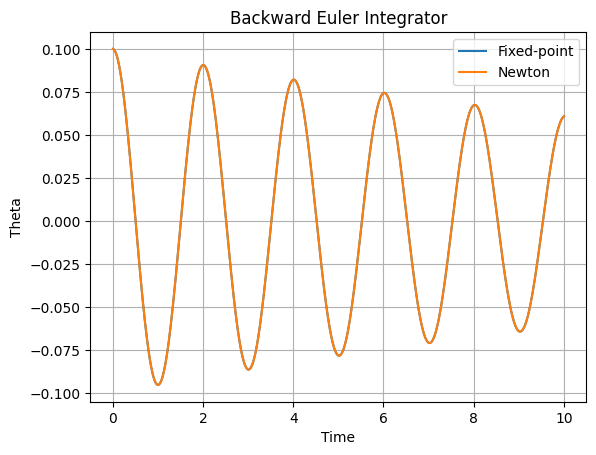

Max difference between fixed-point and Newton: 7.300764112542352e-06


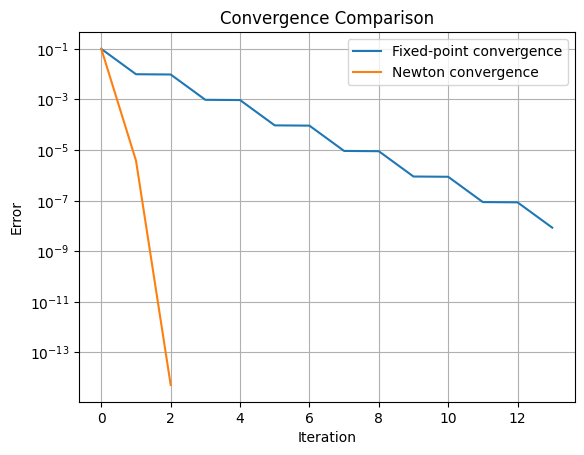

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve
from scipy.optimize import approx_fprime


# ----------------------------
# Pendulum Dynamics
# ----------------------------
def pendulum_dynamics(x):
    l = 1.0
    g = 9.81
    theta, theta_dot = x
    theta_ddot = -(g / l) * np.sin(theta)
    return np.array([theta_dot, theta_ddot])


# ----------------------------
# Backward Euler: Fixed Point
# ----------------------------
def backward_euler_step_fixed_point(fun, x0, h):
    xn = x0.copy()
    e = [norm(x0 + h * fun(xn) - xn)]
    while e[-1] > 1e-8:
        xn = x0 + h * fun(xn)
        e.append(norm(x0 + h * fun(xn) - xn))
    return xn, e


# ----------------------------
# Backward Euler: Newton Method
# ----------------------------
def backward_euler_step_newton(fun, x0, h):
    xn = x0.copy()
    r = x0 + h * fun(xn) - xn
    e = [norm(r)]
    while e[-1] > 1e-8:
        # Jacobian approximation using finite differences
        def residual(x): return x0 + h * fun(x) - x
        eps = np.sqrt(np.finfo(float).eps)
        J = np.zeros((len(xn), len(xn)))
        for i in range(len(xn)):
            def fi(x): return residual(x)[i]
            J[i, :] = approx_fprime(xn, fi, eps)
        xn = xn - solve(J, r)
        r = x0 + h * fun(xn) - xn
        e.append(norm(r))
    return xn, e


# ----------------------------
# Full Trajectory: Fixed Point
# ----------------------------
def backward_euler_fixed_point(fun, x0, Tf, h):
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0
    for k in range(len(t) - 1):
        x_hist[:, k + 1], _ = backward_euler_step_fixed_point(fun, x_hist[:, k], h)
    return x_hist, t


# ----------------------------
# Full Trajectory: Newton
# ----------------------------
def backward_euler_newton(fun, x0, Tf, h):
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0
    for k in range(len(t) - 1):
        x_hist[:, k + 1], _ = backward_euler_step_newton(fun, x_hist[:, k], h)
    return x_hist, t


# ----------------------------
# Simulate and Compare
# ----------------------------
x0 = np.array([0.1, 0.0])
x_hist1, t_hist1 = backward_euler_fixed_point(pendulum_dynamics, x0, 10, 0.01)
x_hist2, t_hist2 = backward_euler_newton(pendulum_dynamics, x0, 10, 0.01)

plt.plot(t_hist1, x_hist1[0, :], label="Fixed-point")
plt.plot(t_hist2, x_hist2[0, :], label="Newton")
plt.xlabel("Time")
plt.ylabel("Theta")
plt.legend()
plt.title("Backward Euler Integrator")
plt.grid(True)
plt.show()

# ----------------------------
# Compare Difference
# ----------------------------
max_diff = np.max(np.abs(x_hist1 - x_hist2))
print("Max difference between fixed-point and Newton:", max_diff)

# ----------------------------
# Plot Convergence per Method
# ----------------------------
_, e1 = backward_euler_step_fixed_point(pendulum_dynamics, x0, 0.1)
_, e2 = backward_euler_step_newton(pendulum_dynamics, x0, 0.1)

plt.semilogy(e1, label="Fixed-point convergence")
plt.semilogy(e2, label="Newton convergence")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()
